# People Analytics

Employee turn over is a very costly problem for a company. The cost of replacing an old employee is huge adding the time and effort.

In this project, I am going to use data science to understand why and where employees are more tend to move and give out some of my quantitative conclusion.

By understanding the main reasons of employee churn, the company can have better action on how to improve the employee retention rate.

# Index:
* [Data Acquistion](#Data Acquistion)
+ [Data Cleaning](#Data Cleaning)
  + [Create a company_headcount table](#HeadCount)
* [Exploratory Data Analysis](#Exploratory Data Analysis)
  + [Explore the distribution of length of employment](#Distribution of Length of Employment)
* [Feature Engineering](#Feature Engineering)
* [Model Development and Validation](#Model Development and Validation)
* [Actionable Insights and Discussion](#Actionable Insights and Discussion)

## Data Acquistion

The data set has a comprehensive information about employees. It has seven columns including employee_id, company_id, department, senority, salary, join_date and quit_date.

## Data Cleaning

In [56]:
library(dplyr)
library(rpart)
library(ggplot2)
library(scales)
library(randomForest)

Warning message:
"package 'randomForest' was built under R version 3.4.2"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

The following object is masked from 'package:dplyr':

    combine



In [6]:
# load in the data
data=read.csv("E:/DataArtist/THC/PeopleAnalytic/employee_retention_data.csv")
# observe the data 
str(data)

'data.frame':	24702 obs. of  7 variables:
 $ employee_id: num  13021 825355 927315 662910 256971 ...
 $ company_id : int  7 7 4 7 2 4 4 2 9 1 ...
 $ dept       : Factor w/ 6 levels "customer_service",..: 1 5 5 1 2 2 1 1 4 6 ...
 $ seniority  : int  28 20 14 20 23 14 21 4 7 7 ...
 $ salary     : num  89000 183000 101000 115000 276000 165000 107000 30000 160000 104000 ...
 $ join_date  : Factor w/ 995 levels "2011-01-24","2011-01-25",..: 643 459 758 264 148 205 558 633 380 280 ...
 $ quit_date  : Factor w/ 664 levels "2011-10-13","2011-10-14",..: 643 364 NA 229 428 267 NA NA 640 NA ...


In [8]:
# change the data type in the data frame
data$company_id=as.factor(data$company_id)
data$join_date=as.Date(data$join_date)
data$quit_date=as.Date(data$quit_date)
# check the descriptive statistics of the data
summary(data)

  employee_id       company_id                 dept        seniority    
 Min.   :    36   1      :8486   customer_service:9180   Min.   : 1.00  
 1st Qu.:250134   2      :4222   data_science    :3190   1st Qu.: 7.00  
 Median :500793   3      :2749   design          :1380   Median :14.00  
 Mean   :501604   4      :2062   engineer        :4613   Mean   :14.13  
 3rd Qu.:753137   5      :1755   marketing       :3167   3rd Qu.:21.00  
 Max.   :999969   6      :1291   sales           :3172   Max.   :99.00  
                  (Other):4137                                          
     salary         join_date            quit_date         
 Min.   : 17000   Min.   :2011-01-24   Min.   :2011-10-13  
 1st Qu.: 79000   1st Qu.:2012-04-09   1st Qu.:2013-06-28  
 Median :123000   Median :2013-06-24   Median :2014-06-20  
 Mean   :138183   Mean   :2013-06-29   Mean   :2014-05-02  
 3rd Qu.:187000   3rd Qu.:2014-09-17   3rd Qu.:2015-03-27  
 Max.   :408000   Max.   :2015-12-10   Max.   :2015-12-0

### Create Company HeadCount Table

In [24]:
#create a list of unique days for the table
unique_dates=seq(as.Date("2011/01/24"),as.Date("2015/12/13"),by="day")
# create a list of unique company
unique_companies=unique(data$company_id)
# cross join two columns
data_headcount=merge(unique_dates,unique_companies,by=NULL)
colnames(data_headcount)=c("date","company_id")
# calculate how many people joined each day and each company
data_join=data%>%group_by(join_date,company_id)%>%summarise(join_count=length(join_date))
# calculate how many people leave each day and each company
data_leave=data%>%group_by(quit_date,company_id)%>%summarise(leave_count=length(quit_date))

In [18]:
# left join the leava and join with data_headcount
data_headcount=merge(data_headcount,data_join,by.x=c("date","company_id"),by.y=c("join_date","company_id"),all.x=TRUE)

In [19]:
data_headcount=merge(data_headcount,data_leave,by.x=c("date","company_id"),by.y=c("quit_date","company_id"),all.x=TRUE) # replace the NAs with zeros

In [20]:
data_headcount$join_count[is.na(data_headcount$join_count)]=0
data_headcount$leave_count[is.na(data_headcount$leave_count)]=0

In [21]:
# calculate the culmulative sum of the join and leave
data_headcount=data_headcount%>%group_by(company_id)%>%mutate(join_cumsum=cumsum(join_count),leave_cumsum=cumsum(leave_count))

In [23]:
data_headcount$count=data_headcount$join_cumsum-data_headcount$leave_cumsum
data_headcount_table=data.frame(data_headcount[,c("date","company_id","count")])
head(data_headcount,20)

date,company_id,join_count,leave_count,join_cumsum,leave_cumsum,count
2011-01-24,1,25,0,25,0,25
2011-01-24,2,17,0,17,0,17
2011-01-24,3,9,0,9,0,9
2011-01-24,4,12,0,12,0,12
2011-01-24,5,5,0,5,0,5
2011-01-24,6,3,0,3,0,3
2011-01-24,7,1,0,1,0,1
2011-01-24,8,6,0,6,0,6
2011-01-24,9,3,0,3,0,3
2011-01-24,10,0,0,0,0,0


## Exploratory Data Analysis

### Distribution of Length of Employment

Warning message:
"Removed 11192 rows containing non-finite values (stat_bin)."

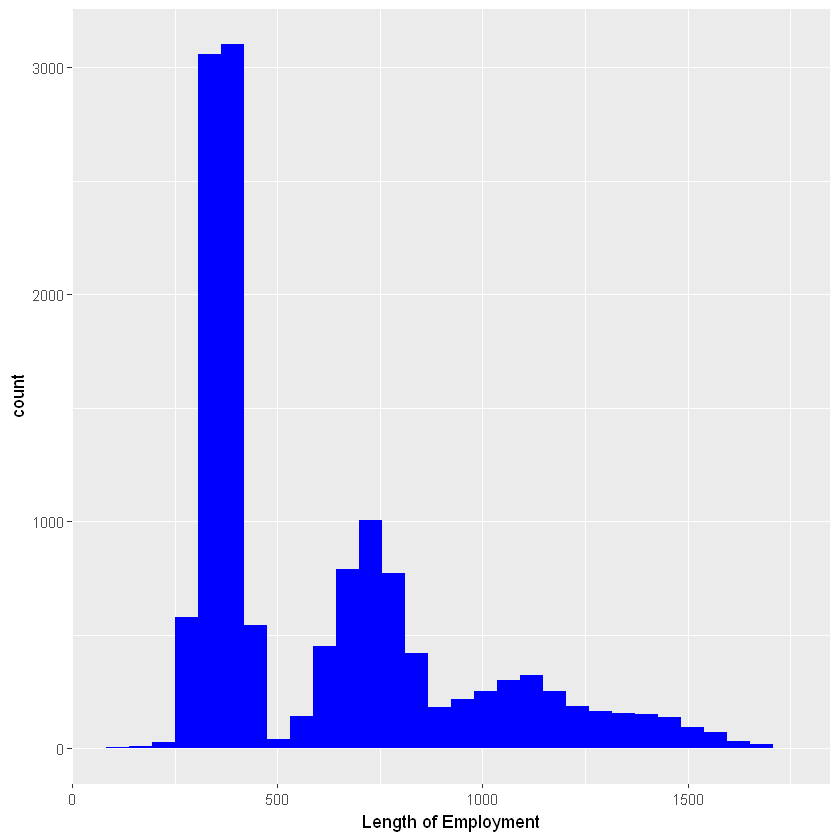

In [35]:
data$employment_length=as.numeric(data$quit_date-data$join_date)
# consider the seasonality factor
data$week_of_year=as.numeric(format(data$quit_date,"%U"))
# Plot the employee length in days
qplot(data$employment_length,geom="histogram",xlab="Length of Employment",
      bins=30,fill=I("blue"))

I can find that people tend to leave at the first and the second year anniversary of their employment.

## Model Development

I am now going to build a simple decision tree model to find what's the most important factor that differentiating people work longer than 13 months and people work less than 13 months.

In [39]:
data=subset(data,data$join_date<as.Date("2015/12/13")-(365+31))
data$early_quitter=as.factor(ifelse(is.na(data$quit_date)|as.numeric(data$quit_date-data$join_date)>396,0,1))

In [40]:
tree=rpart(early_quitter~.,data[,c("company_id","dept","seniority","early_quitter","salary")],control=rpart.control(minbucket=30,maxdepth=3,cp=0.000001),parms=list(prior=c(0.5,0.5)))
tree

n= 19270 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 19270 9635.0000 0 (0.5000000 0.5000000)  
  2) salary>=224500 2764  855.3351 0 (0.6528040 0.3471960) *
  3) salary< 224500 16506 8026.7840 1 (0.4776014 0.5223986)  
    6) salary< 62500 2887 1249.7210 0 (0.5498859 0.4501141) *
    7) salary>=62500 13619 6500.0510 1 (0.4632968 0.5367032) *

From the decision tree, we can find that the salary is the most deciding factor of the long-term employee and early quitter.

The result of the decision tree model is consistent with my guessing, people make a lot of money and very little money in the company is very less likely to leave. The former people are very comfortable with the situation and the latter is very marketable in the job searching market. People in the middle is more likely to change the job. We will further plot the leaving rate by the salary percentile to show the trend.

In [46]:
data$salary_percentile=cut(data$salary,breaks=quantile(data$salary,probs=seq(0,1,0.02)),
                          include.lowest=TRUE,labels = 1:50)

In [47]:
data_proportion_by_percentile=data%>%
group_by(salary_percentile)%>%
summarize(proportion_early_quitters=length(early_quitter[early_quitter==1])/length(early_quitter))

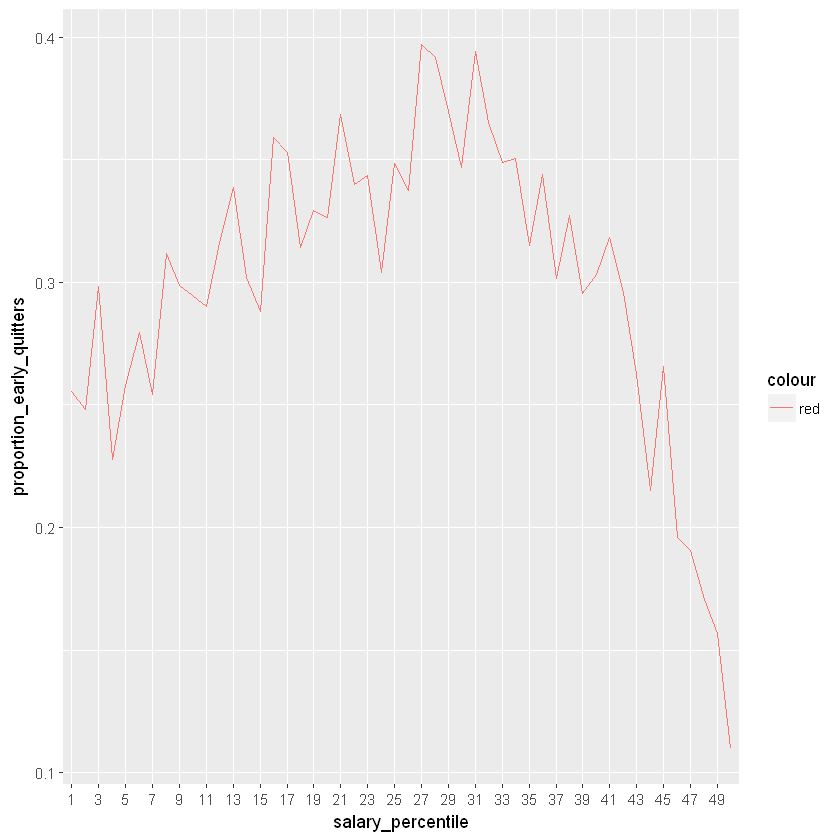

In [51]:
qplot(salary_percentile,proportion_early_quitters,data=data_proportion_by_percentile,
      geom="line",group=1,col="red")+scale_x_discrete(breaks=seq(1,50,by=2))

From the plot, we can definitely find a U-Curve pattern. People's salary range in the middle(21%-35%) has the highest early leave rate.

### Random Forest Model

I will also build a simple random forest model to see the rank of variable importance that will differentiate the early leaver and long-term employeer.


In [54]:
head(data)

employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length,week_of_year,early_quitter,salary_percentile
13021,7,customer_service,28,89000,2014-03-24,2015-10-30,585,43,0,15
825355,7,marketing,20,183000,2013-04-29,2014-04-04,340,13,1,37
927315,4,marketing,14,101000,2014-10-13,NA,NA,NA,0,19
662910,7,customer_service,20,115000,2012-05-14,2013-06-07,389,22,1,23
256971,2,data_science,23,276000,2011-10-17,2014-08-22,1040,33,0,47
509529,4,data_science,14,165000,2012-01-30,2013-08-30,578,34,0,34


In [90]:
set.seed(3456)
trainIndex=sample(nrow(data),size=nrow(data)*0.66)
train_data=data[trainIndex,]
test_data=data[-trainIndex,]

In [91]:
head(data)

employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length,week_of_year,early_quitter,salary_percentile
13021,7,customer_service,28,89000,2014-03-24,2015-10-30,585,43,1,15
825355,7,marketing,20,183000,2013-04-29,2014-04-04,340,13,2,37
927315,4,marketing,14,101000,2014-10-13,NA,NA,NA,1,19
662910,7,customer_service,20,115000,2012-05-14,2013-06-07,389,22,2,23
256971,2,data_science,23,276000,2011-10-17,2014-08-22,1040,33,1,47
509529,4,data_science,14,165000,2012-01-30,2013-08-30,578,34,1,34


In [92]:
rf2=randomForest(y=train_data$early_quitter,x=train_data[,c(3,4,5)],
                 y_test=test_data$early_quitter,x_test=test_data[,c(3,4,5)],
                 ntree=100,mtry=2,keep.forest = TRUE)
rf2


Call:
 randomForest(x = train_data[, c(4, 5)], y = train_data$early_quitter,      ntree = 100, mtry = 2, keep.forest = TRUE, y_test = test_data$early_quitter,      x_test = test_data[, c(4, 5)]) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 2

        OOB estimate of  error rate: 36.89%
Confusion matrix:
     1    2 class.error
1 7117 1823   0.2039150
2 2869  909   0.7593965

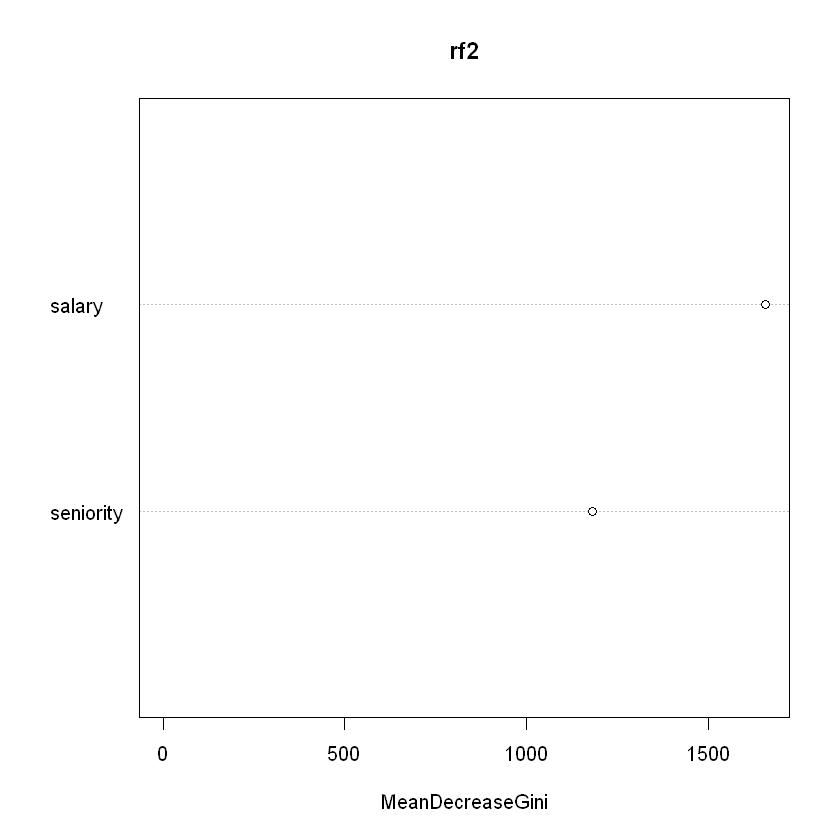

In [93]:
varImpPlot(rf2)

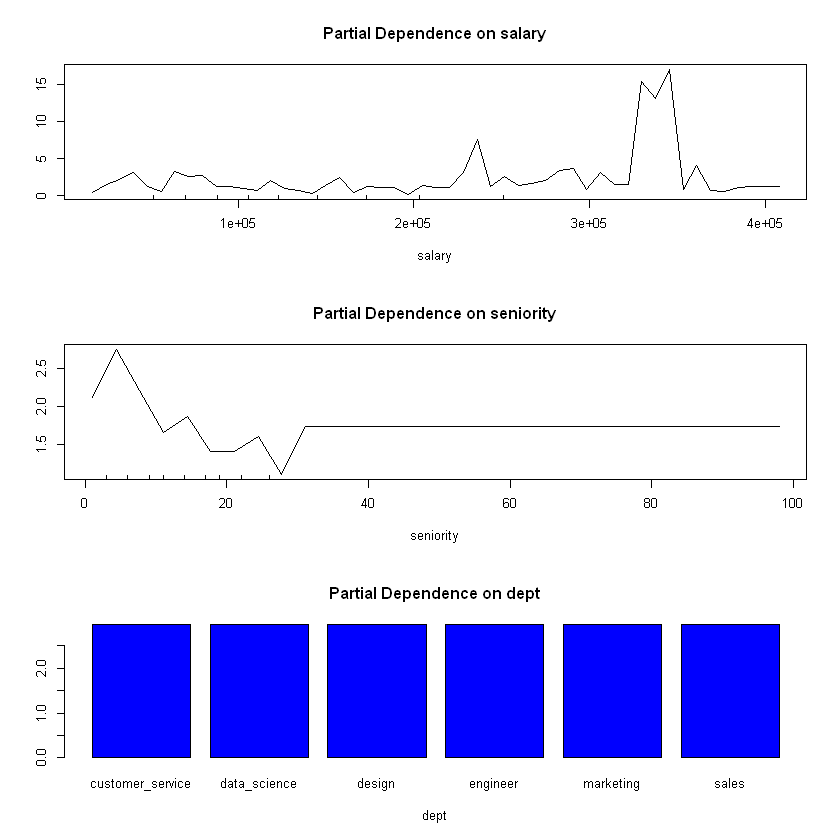

In [98]:
op=par(mfrow=c(3,1))
partialPlot(rf2, train_data[,c(3,4,5)], salary, 1)
partialPlot(rf2, train_data[,c(3,4,5)], seniority, 1)
partialPlot(rf2, train_data[,c(3,4,5)], dept, 1)

From the above analysis, we can find that:
+ Salary and seniority is the two most important factors that will influence the employment retention.
+ The factor of department is not quite important and cannot predict the retention rate very well. 

## Actionable Insights and Discussion

+ I can basically find that people in the mid range of the salary have a high leave rate. So the human resource department should pay more attention to them and give them more support or make them feel supported in the company.
+ I need to do further analyses regarding the salary optimization in the near future.
+ The year anniversary and the beginning of the year is a sensitive time period, we should pay more attention to the group dynamics in the company.